# Relationship b/w Entities in Question to prediction of Answer Span in Paragraph

Dataset: SQuAD v2.0 - machine reading comprehension

Models: XLNet, BERT

Entities captured from Google NLU API

Question: What is `Pr(answer-span is correct | entity in question = x)`?

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache using fc-list. This may take a moment.


In [2]:
with open("squaddata/dev-annotated-v2.0.json") as f:
    ds = json.load(f)

In [3]:
def get_by_entities(em_file, f1_file):
    with open(em_file) as f:
        ds_em = json.load(f)
    with open(f1_file) as f:
        ds_f1 = json.load(f)
    
    # each item has qid, q, entity-types, em, f1
    items = []
    for topic in ds["data"]:
        for para in topic["paragraphs"]:
            for qas in para["qas"]:
                qid = qas["id"]
                entities = [e["type"] for e in qas["question_annotation"].get("entities", [])]
                items.append(dict(
                    qid=qid,
                    question=qas["question"],
                    entities=list(set(entities)),
                    em=ds_em[qid],
                    f1=ds_f1[qid]
                ))
    df_items = pd.DataFrame(items)

    group_by_ent = {}
    avg_items = []

    for i, r in df_items.iterrows():
        for ent in r["entities"] or []:
            group_by_ent[ent] = group_by_ent.get(ent, {"tot": 0, "em": 0, "f1": 0})
            group_by_ent[ent]["tot"] += 1
            group_by_ent[ent]["em"] += r["em"]
            group_by_ent[ent]["f1"] += r["f1"]

    for ent, perf in group_by_ent.items():
        avg_em = perf["em"] / perf["tot"]
        avg_f1 = perf["f1"] / perf["tot"]
        avg_items.append({"entity": ent, "avg_em": avg_em, "avg_f1": avg_f1})

    return avg_items

In [4]:
bert = get_by_entities(
    "bert/predictions_exact.json",
    "bert/predictions_f1.json")

xlnet = get_by_entities(
    "xlnet/predictions_exact.json",
    "xlnet/predictions_f1.json")

In [5]:
for x in bert:
    x["model"] = "bert"
for x in xlnet:
    x["model"] = "xlnet"

df_avg = pd.DataFrame(bert+xlnet)

In [6]:
df_avg

,avg_em,avg_f1,entity,model
0,0.799754,0.829509,LOCATION,bert
1,0.791338,0.820667,PERSON,bert
2,0.793282,0.824748,OTHER,bert
3,0.807057,0.831325,NUMBER,bert
4,0.791028,0.823781,EVENT,bert
5,0.820513,0.854208,WORK_OF_ART,bert
6,0.810491,0.844674,ORGANIZATION,bert
7,0.789298,0.824903,CONSUMER_GOOD,bert
8,0.860817,0.876189,DATE,bert
9,0.769231,0.840237,PRICE,bert


Text(0.5,0,'Entity in Question')

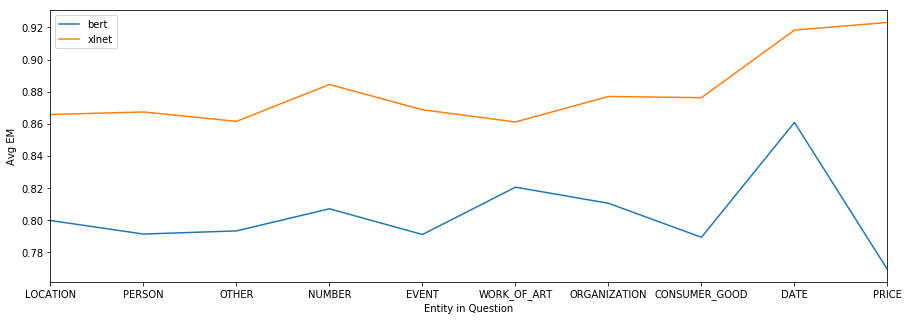

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
for label, df in df_avg.groupby("model"):
    df.plot(x="entity", y="avg_em", ax=ax, label=label)
ax.set_ylabel("Avg EM")
ax.set_xlabel("Entity in Question")

Text(0.5,0,'Entity in Question')

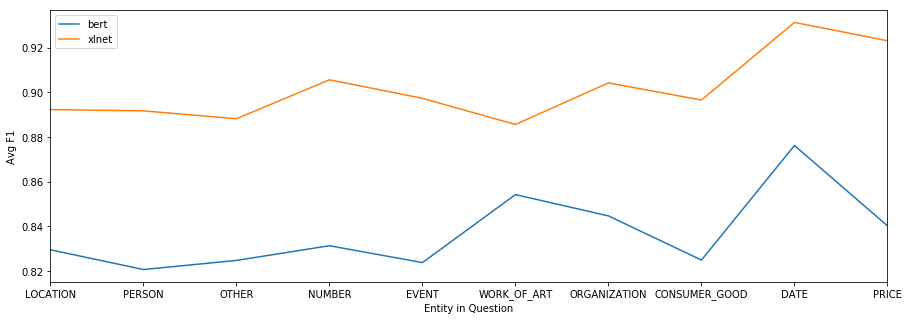

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
for label, df in df_avg.groupby("model"):
    df.plot(x="entity", y="avg_f1", ax=ax, label=label)
ax.set_ylabel("Avg F1")
ax.set_xlabel("Entity in Question")

# contribution of entities

In [22]:
def get_onehot_entities(em_file, f1_file):
    with open(em_file) as f:
        ds_em = json.load(f)
    with open(f1_file) as f:
        ds_f1 = json.load(f)
    
    # each item has qid, q, entity-types, em, f1
    all_entities = ["LOCATION", "PERSON", "OTHER", "NUMBER",
                    "EVENT", "WORK_OF_ART", "ORGANIZATION", "CONSUMER_GOOD", "DATE", "PRICE"]
    items = []
    for topic in ds["data"]:
        for para in topic["paragraphs"]:
            for qas in para["qas"]:
                qid = qas["id"]
                entities = [e["type"] for e in qas["question_annotation"].get("entities", [])]
                each_item = {"qid": qid, "question": qas["question"], "em": ds_em[qid], "f1": ds_f1[qid]}
                for e in all_entities:
                    each_item[e] = int(e in entities)
                items.append(each_item)
    df_items = pd.DataFrame(items)
    return df_items

bert_oh = get_onehot_entities(
    "bert/predictions_exact.json",
    "bert/predictions_f1.json")

xlnet_oh = get_onehot_entities(
    "xlnet/predictions_exact.json",
    "xlnet/predictions_f1.json")

bert_oh["model"] = "bert"
xlnet_oh["model"] = "xlnet"

In [23]:
ds_oh = pd.concat([bert_oh, xlnet_oh])
ds_oh.head()

,CONSUMER_GOOD,DATE,EVENT,LOCATION,NUMBER,ORGANIZATION,OTHER,PERSON,PRICE,WORK_OF_ART,em,f1,qid,question,model
0,0,0,0,1,0,0,0,0,0,0,1,1.0,56ddde6b9a695914005b9628,In what country is Normandy located?,bert
1,0,0,0,1,0,0,0,1,0,0,1,1.0,56ddde6b9a695914005b9629,When were the Normans in Normandy?,bert
2,0,0,0,1,0,0,1,0,0,0,1,1.0,56ddde6b9a695914005b962a,From which countries did the Norse originate?,bert
3,0,0,0,0,0,0,1,1,0,0,1,1.0,56ddde6b9a695914005b962b,Who was the Norse leader?,bert
4,0,0,0,0,0,0,1,1,0,0,1,1.0,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,bert


In [24]:
import statsmodels.formula.api as smf

In [38]:
X = bert_oh[["LOCATION", "PERSON", "OTHER", "NUMBER", "EVENT", "WORK_OF_ART", "ORGANIZATION", "CONSUMER_GOOD", "DATE", "PRICE"]]
Y = bert_oh["f1"]
res = smf.OLS(Y, X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     f1   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     3265.
Date:                Tue, 23 Jul 2019   Prob (F-statistic):               0.00
Time:                        08:13:24   Log-Likelihood:                -7821.0
No. Observations:               11873   AIC:                         1.566e+04
Df Residuals:                   11863   BIC:                         1.574e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
LOCATION          0.2967      0.008     35.804      0.000       0.280       0.313
PERSON            0.2619      0.009     30.353      0.000       0.245       0.279
OTHER             0.5759      0.006     93.576      0.000       0.564       0.588
NUMBER            0.0996      0.015      6.723      0.000       0.071       0.129
EVENT             0.2261      0.016     14.187      0.000       0.195       0.257
WORK_OF_ART       0.2589      0.022     11.793      0.000       0.216       0.302
ORGANIZATION      0.2685      0.010     27.457      0.000       0.249       0.288
CONSUMER_GOOD     0.2128      0.027      7.790      0.000       0.159       0.266
DATE              0.0986      0.023      4.256      0.000       0.053       0.144
PRICE            -0.0061      0.130     -0.046      0.963      -0.261       0.249
==============================================================================
Omnibus:                     1331.276   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1817.574
Skew:                          -0.934   Prob(JB):                         0.00
Kurtosis:                       3.433   Cond. No.                         30.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
X = xlnet_oh[["LOCATION", "PERSON", "OTHER", "NUMBER", "EVENT", "WORK_OF_ART", "ORGANIZATION", "CONSUMER_GOOD", "DATE", "PRICE"]]
Y = xlnet_oh["f1"]
res = smf.OLS(Y, X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     f1   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     4457.
Date:                Tue, 23 Jul 2019   Prob (F-statistic):               0.00
Time:                        08:13:22   Log-Likelihood:                -6858.1
No. Observations:               11873   AIC:                         1.374e+04
Df Residuals:                   11863   BIC:                         1.381e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
LOCATION          0.3169      0.008     41.463      0.000       0.302       0.332
PERSON            0.2929      0.008     36.813      0.000       0.277       0.309
OTHER             0.6177      0.006    108.853      0.000       0.607       0.629
NUMBER            0.1335      0.014      9.768      0.000       0.107       0.160
EVENT             0.2533      0.015     17.240      0.000       0.225       0.282
WORK_OF_ART       0.2414      0.020     11.924      0.000       0.202       0.281
ORGANIZATION      0.2824      0.009     31.314      0.000       0.265       0.300
CONSUMER_GOOD     0.2371      0.025      9.413      0.000       0.188       0.286
DATE              0.0697      0.021      3.261      0.001       0.028       0.112
PRICE            -0.0007      0.120     -0.006      0.995      -0.236       0.235
==============================================================================
Omnibus:                     1548.940   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2335.657
Skew:                          -0.949   Prob(JB):                         0.00
Kurtosis:                       4.058   Cond. No.                         30.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""